<a href="https://colab.research.google.com/github/AvijitKarmoker1992/GoldForecast/blob/main/GoldForecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In order for us to predict future gold price, we need to know what factors affects Gold Price.

**Factors that affects Gold Price are as follows:**

  - Historical gold prices themselves (trend, seasonality)

  - Macroeconomic indicators (inflation, interest rates, USD index)

  - Geopolitical events

  - Commodity markets (oil price, silver price)

In [33]:
!pip -q install gdown

!pip -q uninstall -y pytorch-lightning lightning-utilities || true

!pip -q install "numpy<2" "pandas>=1.5,<2.3" "torch==2.3.1" "lightning==2.4.0" "pytorch-forecasting==1.4.0"

import os, time;




ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytorch-tabular 1.1.1 requires pytorch-lightning<2.5.0,>=2.0.0, but you have pytorch-lightning 2.5.3 which is incompatible.
pytorch-tabular 1.1.1 requires torchmetrics<1.6.0,>=0.10.0, but you have torchmetrics 1.8.1 which is incompatible.


In [37]:
import pandas as pd, gdown, os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
import torch

# Use Lightning 2.x everywhere
import lightning.pytorch as L
import pytorch_forecasting as pf
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.models import TemporalFusionTransformer
from pytorch_forecasting.metrics import MAE
import lightning.pytorch as L

import statsmodels.api as sm
import itertools





# We get our core dataset : Historical Gold Price Dataset

In [6]:
# Now we access the gold price yearly data from gdrive

file_id = "1wkjbsFCYLOUY64by7Bn-73_ADUbQawTy"
url = f"https://drive.google.com/uc?id={file_id}"
out_path = "/content/gold_price_yearly.csv"

# Download
if not os.path.exists(out_path):
    gdown.download(url, out_path, quiet=False)

# function to load the gold price data
def load_table(path):
    # Trying CSV with delimiter sniffing
    try:
        return pd.read_csv(path, sep=None, engine="python")
    except Exception:
        pass
    # Trying as Excel (in case it's actually xls/xlsx or CSV with wrong ext)
    try:
        return pd.read_excel(path)
    except Exception as e:
        raise RuntimeError(f"Could not parse the file. Last error: {e}")

df_historical_gold_price = load_table(out_path)
display(df_historical_gold_price.head())


,Year,Average Closing Price,Year Open,Year High,Year Low,Year Range Price,Year Close,Annual % Change
0,1969,41.10,41.80,43.75,35.00,8.75,35.21,-0.161
1,1970,35.96,35.13,39.19,34.78,4.41,37.38,0.062
2,1971,40.80,37.33,43.90,37.33,6.57,43.50,0.164
3,1972,58.17,43.73,70.00,43.73,26.27,64.70,0.487
4,1973,97.12,64.99,127.00,64.10,62.90,112.25,0.735


# Macroeconomics datasets loading - USD Index

# downloaded data from Kaggle, https://www.kaggle.com/datasets/balabaskar/us-dollar-index-data?select=US+Dollar+Index+Historical+Data.csv, 2025

In [7]:
# Now we download Macroeconomics datasets:

#USD index datasets

file_id = '1ICyVCmS_cnrHJU3UOtySQGlvbRaSWdZj'
download_link = f'https://drive.google.com/uc?export=download&id={file_id}'

# Now I will read the data using the raw download link
# Using engine='python' can sometimes help with parsing issues.
df_usd = pd.read_csv(download_link, engine='python')
display(df_usd.head())

,Date,Price,Open,High,Low,Change %
0,"Jan 02, 2001",108.77,109.33,109.65,108.64,-0.72%
1,"Jan 03, 2001",110.17,108.59,110.34,108.09,1.29%
2,"Jan 04, 2001",108.81,110.30,110.40,108.51,-1.23%
3,"Jan 05, 2001",108.42,108.64,109.31,108.26,-0.36%
4,"Jan 08, 2001",108.86,108.33,109.19,108.23,0.41%


# Macroeconomics datasets loading - Interests Rate

# downloaded the data from kaggle, https://www.kaggle.com/datasets/shreyaskeote23/interest-rate-dataset, 2025

In [8]:
# Now we download Macroeconomics datasets:

#Interest Rates datasets
file_id = '1-RmjE4uPTOm1TG_4-pGMmxKSL9s0ZgNS'
download_link = f'https://drive.google.com/uc?export=download&id={file_id}'

# Now I will read the data using the raw download link
# Using engine='python' can sometimes help with parsing issues.
df_interests_rates = pd.read_csv(download_link, engine='python')
display(df_interests_rates.head())

,Unnamed: 0,Year,Average_Closing_price,Year_Open,Year_High,Year_Low,Year_Close,Annual_Change
0,0,2024,4.31%,3.95%,4.70%,3.87%,4.28%,10.31%
1,1,2023,3.96%,3.79%,4.98%,3.30%,3.88%,0.00%
2,2,2022,2.95%,1.63%,4.25%,1.63%,3.88%,155.26%
3,3,2021,1.45%,0.93%,1.74%,0.93%,1.52%,63.44%
4,4,2020,0.89%,1.88%,1.88%,0.52%,0.93%,-51.56%


#Macroeconomics datasets loading - Global Inflation Rate

#downloaded the data from kaggle, https://www.kaggle.com/datasets/sazidthe1/global-inflation-data, 2025

In [9]:
# Now we download Macroeconomics datasets:

#Global Inflation Rates datasets
file_id = '16fk3Ln5fqJwqPYYH0XuPhPNEkHptNGuP'
download_link = f'https://drive.google.com/uc?export=download&id={file_id}'

# Now I will read the data using the raw download link
# Using engine='python' can sometimes help with parsing issues.
df_global_inflation_rates = pd.read_csv(download_link, engine='python')
display(df_global_inflation_rates.head())

,country_name,indicator_name,1980,1981,1982,1983,1984,1985,1986,1987,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Afghanistan,Annual average inflation (consumer prices) rate,13.4,22.2,18.2,15.9,20.4,8.7,-2.1,18.4,...,-0.66,4.38,4.98,0.63,2.3,5.44,5.06,13.71,9.1,NaN
1,Albania,Annual average inflation (consumer prices) rate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.90,1.30,2.00,2.00,1.4,1.60,2.00,6.70,4.8,4.0
2,Algeria,Annual average inflation (consumer prices) rate,9.7,14.6,6.6,7.8,6.3,10.4,14.0,5.9,...,4.80,6.40,5.60,4.30,2.0,2.40,7.20,9.30,9.0,6.8
3,Andorra,Annual average inflation (consumer prices) rate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.10,-0.40,2.60,1.00,0.5,0.10,1.70,6.20,5.2,3.5
4,Angola,Annual average inflation (consumer prices) rate,46.7,1.4,1.8,1.8,1.8,1.8,1.8,1.8,...,9.20,30.70,29.80,19.60,17.1,22.30,25.80,21.40,13.1,22.3


#Macroeconomics datasets loading - Crude oil

#downloaded the data from kaggle, https://www.kaggle.com/datasets/sc231997/crude-oil-price, 2025

In [10]:
# Now we download Macroeconomics datasets:

#Global Inflation Rates datasets
file_id = '1p5pRqhLPxtVN1ukKDrMlalU5XKitn0Xj'
download_link = f'https://drive.google.com/uc?export=download&id={file_id}'

# Now I will read the data using the raw download link
# Using engine='python' can sometimes help with parsing issues.
df_crude_oil_prices = pd.read_csv(download_link, engine='python')
display(df_crude_oil_prices.head())

,date,price,percentChange,change
0,1983-03-01 00:00:00+00:00,29.27,NaN,NaN
1,1983-04-01 00:00:00+00:00,30.63,4.646,1.36
2,1983-05-01 00:00:00+00:00,30.25,-1.241,-0.38
3,1983-06-01 00:00:00+00:00,31.38,3.736,1.13
4,1983-07-01 00:00:00+00:00,32.00,1.976,0.62


# Secondly, we now preprocess all the datsets we accessed and clean the data and remove outliers, NaN, empty rows and other inconsistent data

In [11]:
# function that conducts preprocession of datasets
# it takes the raw datasets and output is the cleaned dataset

def preprocessing_data(raw_data):
    # drop rows with NaN
    # Removed inplace=True as it makes dropna() return None
    df = raw_data.dropna().copy() # Create a copy to avoid modifying the original dataframe

    #we remove outliers from the dataset
    outliers = None # Initialize outliers as an empty list or dictionary if you plan to use it
    # Check if outliers is defined and not empty before iterating
    if outliers:
        for col in outliers:
            if col in df.columns:
                Q1 = df[col].quantile(0.25)
                Q3 = df[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]


    # convert strings columns into lower case
    my_strings_col = df.select_dtypes(include=['object']).columns
    for col in my_strings_col:
        df[col] = df[col].str.lower()

    # normalize the numerical columns, excluding 'Year'
    numerical_columns = df.select_dtypes(include=['number']).columns.tolist()
    if 'Year' in numerical_columns:
        numerical_columns.remove('Year') # Exclude 'Year' from normalization

    for col in numerical_columns:
        min_value = df[col].min()
        max_value = df[col].max()
        # Added a check to prevent division by zero
        if (max_value - min_value != 0):
            df[col] = (df[col] - min_value) / (max_value - min_value)

    # we reset the index
    df.reset_index(drop=True, inplace=True)

    return df

# implementation of preprocessing datasets

cleaned_df_historical_gold_price = preprocessing_data(df_historical_gold_price)

cleaned_df_usd = preprocessing_data(df_usd)

cleaned_df_interests_rates = preprocessing_data(df_interests_rates)

cleaned_df_global_inflation_rates = preprocessing_data(df_global_inflation_rates)

cleaned_df_crude_oil_prices = preprocessing_data(df_crude_oil_prices)

display(cleaned_df_historical_gold_price.head())
display(cleaned_df_usd.head())
display(cleaned_df_interests_rates.head())
display(cleaned_df_global_inflation_rates.head())
display(cleaned_df_crude_oil_prices.head())

,Year,Average Closing Price,Year Open,Year High,Year Low,Year Range Price,Year Close,Annual % Change
0,1969,0.002812,0.003489,0.002258,0.000126,0.007462,0.000000,0.097222
1,1970,0.000000,0.000000,0.000000,0.000000,0.000000,0.001113,0.231884
2,1971,0.002647,0.001151,0.002333,0.001456,0.003714,0.004252,0.293478
3,1972,0.012149,0.004499,0.015258,0.005111,0.037583,0.015125,0.488527
4,1973,0.033455,0.015621,0.043487,0.016743,0.100560,0.039512,0.638285


,Date,Price,Open,High,Low,Change %
0,"jan 02, 2001",0.755296,0.768764,0.769511,0.771766,-0.72%
1,"jan 03, 2001",0.783538,0.753793,0.783499,0.760578,1.29%
2,"jan 04, 2001",0.756102,0.788388,0.784715,0.769121,-1.23%
3,"jan 05, 2001",0.748235,0.754805,0.762619,0.764036,-0.36%
4,"jan 08, 2001",0.757111,0.748533,0.760186,0.763426,0.41%


,Unnamed: 0,Year,Average_Closing_price,Year_Open,Year_High,Year_Low,Year_Close,Annual_Change
0,0.000000,2024,4.31%,3.95%,4.70%,3.87%,4.28%,10.31%
1,0.016393,2023,3.96%,3.79%,4.98%,3.30%,3.88%,0.00%
2,0.032787,2022,2.95%,1.63%,4.25%,1.63%,3.88%,155.26%
3,0.049180,2021,1.45%,0.93%,1.74%,0.93%,1.52%,63.44%
4,0.065574,2020,0.89%,1.88%,1.88%,0.52%,0.93%,-51.56%


,country_name,indicator_name,1980,1981,1982,1983,1984,1985,1986,1987,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,algeria,annual average inflation (consumer prices) rate,0.052485,0.125000,0.060241,0.049343,0.010631,0.001667,0.035002,0.001585,...,0.057258,0.036822,0.014806,0.000744,0.000261,0.002121,0.006409,0.042680,0.027162,0.028169
1,angola,annual average inflation (consumer prices) rate,0.166718,0.011986,0.021687,0.028044,0.007139,0.000935,0.021489,0.001272,...,0.092742,0.131008,0.069932,0.000978,0.001020,0.010561,0.018096,0.108050,0.038525,0.106137
2,antigua and barbuda,annual average inflation (consumer prices) rate,0.081198,0.098459,0.040964,0.029819,0.008691,0.000867,0.020049,0.001410,...,0.026613,0.010078,0.007517,0.000697,0.000231,0.001569,0.002890,0.032955,0.016075,0.008551
3,australia,annual average inflation (consumer prices) rate,0.053720,0.081336,0.098795,0.057153,0.008846,0.001352,0.029575,0.001783,...,0.030645,0.017054,0.006606,0.000708,0.000241,0.001484,0.003644,0.028093,0.018293,0.014085
4,austria,annual average inflation (consumer prices) rate,0.041988,0.058219,0.050602,0.033369,0.010165,0.001055,0.021378,0.001242,...,0.025000,0.015891,0.007062,0.000711,0.000236,0.001697,0.003644,0.038898,0.023836,0.012575


,date,price,percentChange,change
0,1983-04-01 00:00:00+00:00,0.155965,0.412920,0.690986
1,1983-05-01 00:00:00+00:00,0.153033,0.371642,0.655821
2,1983-06-01 00:00:00+00:00,0.161753,0.406539,0.686338
3,1983-07-01 00:00:00+00:00,0.166538,0.394199,0.676031
4,1983-08-01 00:00:00+00:00,0.163374,0.371362,0.655214


# Thirdly, we choose Time Series Model

ADF Statistic: -0.131584671959584
p-value: 0.9462002842238506
❌ Series is not stationary

Testing stationarity of the differenced series:
ADF Statistic: -4.904459993867796
p-value: 3.4183900837313024e-05
✅ Series is stationary


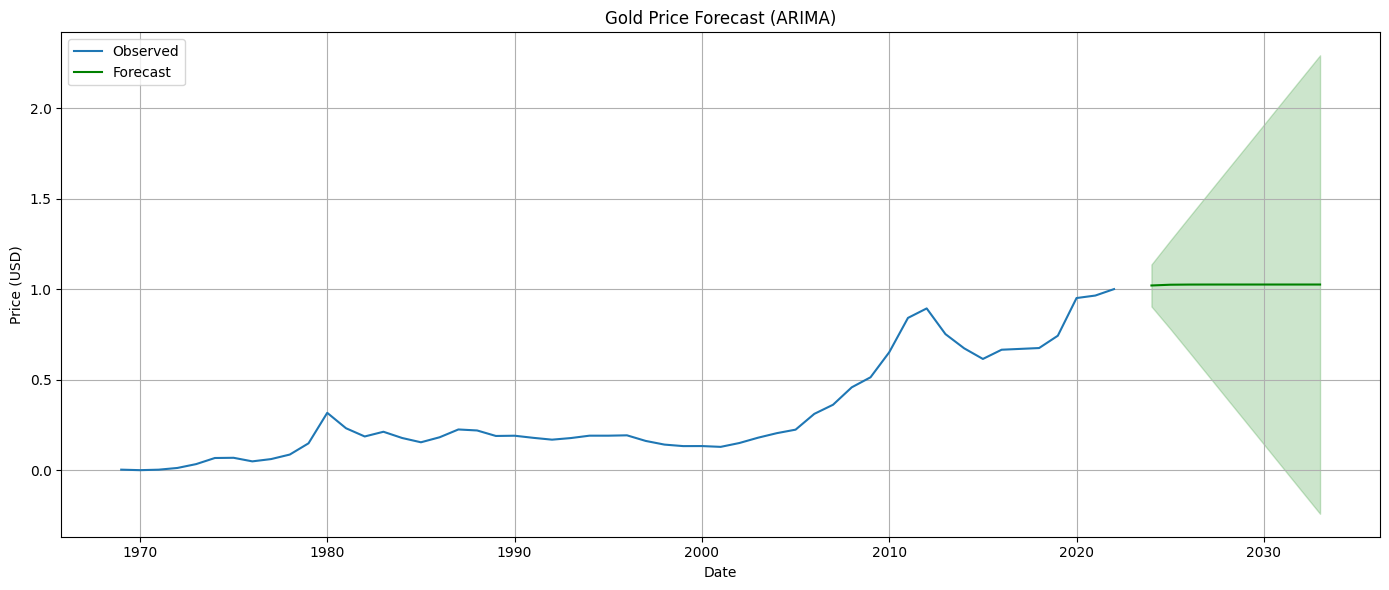

In [12]:
# we choose Time Series Model Univariate

# Step 2: Check Stationarity
def test_stationarity(series):
    result = adfuller(series)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] < 0.05:
        print("✅ Series is stationary")
    else:
        print("❌ Series is not stationary")

# Step 3: Fit SARIMA Model
# Changed default seasonal_order to (0, 0, 0, 0) for non-seasonal data
def fit_sarima(series, order=(1,1,1), seasonal_order=(0,0,0,0), forecast_steps=180):
    # The series index needs to be a DatetimeIndex for SARIMA
    model = SARIMAX(series, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit(disp=False)
    return result

# Step 4: Forecast Future Prices
def forecast_and_plot(model_result, original_series, differenced_series, steps=180):
    forecast_diff = model_result.get_forecast(steps=steps)
    predicted_mean_diff = forecast_diff.predicted_mean
    pred_ci_diff = forecast_diff.conf_int()

    # Invert differencing to get the forecast on the original scale
    forecast = original_series.iloc[-1] + predicted_mean_diff.cumsum()
    pred_ci_lower = original_series.iloc[-1] + pred_ci_diff.iloc[:, 0].cumsum()
    pred_ci_upper = original_series.iloc[-1] + pred_ci_diff.iloc[:, 1].cumsum()


    plt.figure(figsize=(14,6))
    plt.plot(original_series.index, original_series, label="Observed")
    # Create forecast index starting from the end of the observed series index
    forecast_index = pd.date_range(start=original_series.index[-1] + pd.DateOffset(years=1), periods=steps, freq="Y") # Adjusted frequency to 'Y' for yearly data
    plt.plot(forecast_index, forecast, label="Forecast", color='green')
    plt.fill_between(forecast_index, pred_ci_lower, pred_ci_upper, color='green', alpha=0.2) # Use adjusted confidence intervals
    plt.title("Gold Price Forecast (ARIMA)") # Changed title to reflect ARIMA
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# Run Full Pipeline
if __name__ == "__main__":
    gold = cleaned_df_historical_gold_price.copy()
    # Convert 'Year' column to datetime objects and set as index
    gold['Year'] = pd.to_datetime(gold['Year'], format='%Y') # Assuming 'Year' is in 'YYYY' format
    gold.set_index('Year', inplace=True)
    # Explicitly set the frequency to suppress warnings
    gold = gold.asfreq('YS')

    # Using 'Average Closing Price' for the time series analysis
    original_gold_price_series = gold['Average Closing Price']

    # Check stationarity of the original series
    test_stationarity(original_gold_price_series)

    # Use differencing to make the series stationary
    differenced_gold_price_series = original_gold_price_series.diff().dropna()

    # Check stationarity of the differenced series
    print("\nTesting stationarity of the differenced series:")
    test_stationarity(differenced_gold_price_series)


    # Fit the SARIMA model (effectively ARIMA) on the differenced series
    # The order is (p, d, q), where d=1 for first-order differencing
    model_result = fit_sarima(differenced_gold_price_series, order=(1,0,1), seasonal_order=(0,0,0,0)) # Changed order to (1,0,1) as differencing is applied explicitly
    forecast_and_plot(model_result, original_gold_price_series, differenced_gold_price_series, steps=10) # Reduced forecast steps for yearly data visualization

# Now we implement the Machine learning Model:

# Transformer based model

In [38]:
# =========================================
# Evaluation and Training
# =========================================


# ---- helper: build datasets/loaders from raw dataframes ----

def _to_float_series(s: pd.Series) -> pd.Series:
    """Robust numeric cleaner: keeps digits, dot, minus; drops $, %, commas, spaces."""
    s = s.astype(str).str.replace(r"[^0-9.\-]", "", regex=True)
    s = s.replace({"": np.nan})
    return s.astype(float)

def make_train_valid(cleaned_df_historical_gold_price: pd.DataFrame, train_frac: float = 0.8):
    df = cleaned_df_historical_gold_price.copy()

    # --- ensure Year is proper datetime (YYYY) ---
    # works if Year is 1995 / "1995" / "1995-01-01"
    df["Year"] = pd.to_datetime(df["Year"].astype(str).str[:4] + "-01-01", errors="coerce")
    df = df.sort_values("Year").dropna(subset=["Year"])

    # --- keep 1 row per year, regularize to annual freq and fill gaps ---
    df = (df
          .drop_duplicates(subset=["Year"], keep="last")
          .set_index("Year")
          .asfreq("YS"))  # yearly start; creates missing years if any

    # --- numeric cleanup for all model columns ---
    num_cols = [
        "Average Closing Price", "Year Open", "Year High", "Year Low",
        "Year Range Price", "Year Close", "Annual % Change"
    ]
    for c in num_cols:
        if c in df.columns:
            df[c] = _to_float_series(df[c])
        else:
            df[c] = np.nan  # ensure column exists even if missing

    # Fill missing numeric values (forward/back fill over years)
    df[num_cols] = df[num_cols].ffill().bfill()

    # Sanity check: target must be finite
    if not np.isfinite(df["Average Closing Price"]).all():
        bad = df[~np.isfinite(df["Average Closing Price"])]
        raise ValueError("Non-finite values remain in target after cleaning:\n" + str(bad[["Average Closing Price"]].head()))

    # --- add identifiers & time index ---
    df = df.reset_index()                  # bring Year back as a column (optional)
    df["series_id"] = "gold"
    df["time_idx"]  = np.arange(len(df))   # strictly increasing integer index

    # --- chronological split ---
    train_size = int(len(df) * train_frac)
    train_df = df.iloc[:train_size].copy()
    valid_df = df.iloc[train_size:].copy()

    return train_df, valid_df

# usage:


def make_datasets_from_raw(raw_train_df, raw_valid_df, enc_len, pred_len=5, batch_size=64):
    training_ds = TimeSeriesDataSet(
        raw_train_df,
        time_idx="time_idx",
        target="Average Closing Price",
        group_ids=["series_id"],
        min_encoder_length=max(enc_len // 2, 1),
        max_encoder_length=enc_len,
        min_prediction_length=1,
        max_prediction_length=pred_len,
        time_varying_known_reals=["time_idx", "Year Open", "Year High", "Year Low", "Year Range Price"],
        time_varying_unknown_reals=["Average Closing Price", "Year Close", "Annual % Change"],
        static_categoricals=[],
        static_reals=[],
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
    )
    valid_ds = TimeSeriesDataSet.from_dataset(training_ds, raw_valid_df, predict=False, stop_randomization=True)
    train_loader = training_ds.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
    val_loader   = valid_ds.to_dataloader(train=False, batch_size=batch_size, num_workers=0)
    return training_ds, valid_ds, train_loader, val_loader

# helper: per-horizon eval (robust) ----
def eval_per_horizon(model, val_loader, max_h=5):
    with torch.no_grad():
        pred = model.predict(val_loader)  # [N, H]
    if isinstance(pred, np.ndarray):
        pred = torch.from_numpy(pred)
    pred = pred.detach().cpu().numpy()

    ys = []
    for _, y in val_loader:
        if isinstance(y, (list, tuple)):  # (target, weight)
            y = y[0]
        ys.append(y)
    true = torch.cat(ys, dim=0).detach().cpu().numpy()

    H = min(max_h, pred.shape[1], true.shape[1])
    lines, rmse_list = [], []

    for h in range(1, H + 1):
        yh = pred[:, h - 1].astype(np.float64)
        yt = true[:, h - 1].astype(np.float64)
        mask = np.isfinite(yh) & np.isfinite(yt)
        yh, yt = yh[mask], yt[mask]
        used = len(yt)
        dropped = int(pred.shape[0] - used)
        if used == 0:
            lines.append(f"[H={h} steps] Used 0 (dropped {dropped}). RMSE=nan MAE=nan MAPE=nan")
            continue
        rmse = float(np.sqrt(np.mean((yt - yh) ** 2)))
        mae  = float(np.mean(np.abs(yt - yh)))
        nz = yt != 0
        mape = float(np.mean(np.abs((yt[nz] - yh[nz]) / yt[nz]) * 100)) if np.any(nz) else np.nan
        rmse_list.append(rmse)
        lines.append(f"[H={h} steps] Used {used} (dropped {dropped}). RMSE={rmse:.3f} MAE={mae:.3f} MAPE={mape:.2f}%")
    mean_rmse = float(np.nanmean(rmse_list)) if rmse_list else np.nan
    return lines, mean_rmse

# search space
search_space = [
    dict(hidden_size=16, dropout=0.10, lr=0.01,  attn_heads=1, enc_len=12),
    dict(hidden_size=32, dropout=0.10, lr=0.01,  attn_heads=2, enc_len=16),
    dict(hidden_size=32, dropout=0.20, lr=0.01,  attn_heads=2, enc_len=16),
    dict(hidden_size=64, dropout=0.10, lr=0.005, attn_heads=4, enc_len=20),
]

# copying raw data to split into train and test data
train_df, valid_df = make_train_valid(cleaned_df_historical_gold_price, train_frac=0.8)
raw_train_df = train_df.copy()
raw_valid_df = valid_df.copy()

best = None
all_runs = []

# we track current dataset to avoid needless rebuilds
current_enc_len = None
training_ds = validation_ds = train_loader = val_loader = None

# Import CSVLogger
from lightning.pytorch.loggers import CSVLogger

for cfg in search_space:
    # (re)build datasets only if encoder length changes
    if (current_enc_len is None) or (cfg["enc_len"] != current_enc_len):
        training_ds, validation_ds, train_loader, val_loader = make_datasets_from_raw(
            raw_train_df, raw_valid_df, enc_len=cfg["enc_len"], pred_len=5, batch_size=64
        )
        current_enc_len = cfg["enc_len"]

    model = TemporalFusionTransformer.from_dataset(
        training_ds,
        learning_rate=cfg["lr"],
        hidden_size=cfg["hidden_size"],
        attention_head_size=cfg["attn_heads"],
        dropout=cfg["dropout"],
        loss=MAE(),  # aligns with MAE/RMSE reporting
        log_interval=50,
        reduce_on_plateau_patience=3,
    )

    early_stop = EarlyStopping(monitor="val_loss", patience=5, mode="min")
    lr_monitor = LearningRateMonitor(logging_interval="epoch")

    # Initialize CSVLogger and pass it to the Trainer
    logger = CSVLogger("lightning_logs", name="tft_logs")

    trainer = Trainer(
    max_epochs=50,
    gradient_clip_val=0.01,
    enable_checkpointing=False,
    enable_model_summary=False,
    callbacks=[early_stop, lr_monitor],
    logger=logger, # Pass the initialized logger here
    enable_progress_bar=False,
    )
    trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)

    lines, mean_rmse = eval_per_horizon(model, val_loader, max_h=5)
    all_runs.append((cfg, mean_rmse, lines))
    if (best is None) or (mean_rmse < best[1]):
        best = (cfg, mean_rmse, lines, model)

print("\n=== All candidates (mean RMSE across horizons) ===")
for cfg, mean_rmse, _ in all_runs:
    print(f"{cfg} -> mean_RMSE={mean_rmse:.3f}")

print("\n=== Best config ===")
print(best[0])
print("\n".join(best[2]))

# keep best model handy
tft_best = best[3]

# Hyperparameter Tuning Using ARIMA
y_train = raw_train_df["Average Closing Price"].to_numpy(dtype=float)
y_valid = raw_valid_df["Average Closing Price"].to_numpy(dtype=float)
def metrics(y, yhat):
    rmse = float(np.sqrt(np.mean((y - yhat) ** 2)))
    mae  = float(np.mean(np.abs(y - yhat)))
    nz = y != 0
    mape = float(np.mean(np.abs((y[nz] - yhat[nz]) / y[nz]) * 100)) if np.any(nz) else float("nan")
    return rmse, mae, mape

best_arima = None
best_score = np.inf

# Tiny grid — expand if you like
P = [0,1,2]; D = [0,1]; Q = [0,1,2]
for p,d,q in itertools.product(P, D, Q):
    try:
        model = sm.tsa.SARIMAX(y_train, order=(p,d,q),
                               enforce_stationarity=False, enforce_invertibility=False)
        res = model.fit(disp=False)
        y_hat = res.forecast(steps=len(y_valid))
        rmse, mae, mape = metrics(y_valid, y_hat)
        if rmse < best_score:
            best_score = rmse
            best_arima = {"order": (p,d,q), "rmse": rmse, "mae": mae, "mape": mape, "model": res}
    except Exception:
        continue

print("Best ARIMA:", best_arima["order"],
      f'RMSE={best_arima["rmse"]:.3f} MAE={best_arima["mae"]:.3f} MAPE={best_arima["mape"]:.2f}%')
arima_best_model = best_arima["model"]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs



=== All candidates (mean RMSE across horizons) ===
{'hidden_size': 16, 'dropout': 0.1, 'lr': 0.01, 'attn_heads': 1, 'enc_len': 12} -> mean_RMSE=0.198
{'hidden_size': 32, 'dropout': 0.1, 'lr': 0.01, 'attn_heads': 2, 'enc_len': 16} -> mean_RMSE=0.308
{'hidden_size': 32, 'dropout': 0.2, 'lr': 0.01, 'attn_heads': 2, 'enc_len': 16} -> mean_RMSE=0.332
{'hidden_size': 64, 'dropout': 0.1, 'lr': 0.005, 'attn_heads': 4, 'enc_len': 20} -> mean_RMSE=0.332

=== Best config ===
{'hidden_size': 16, 'dropout': 0.1, 'lr': 0.01, 'attn_heads': 1, 'enc_len': 12}
[H=1 steps] Used 9 (dropped 0). RMSE=0.160 MAE=0.152 MAPE=19.15%
[H=2 steps] Used 7 (dropped 2). RMSE=0.157 MAE=0.143 MAPE=16.27%
[H=3 steps] Used 5 (dropped 4). RMSE=0.208 MAE=0.207 MAPE=21.43%
[H=4 steps] Used 3 (dropped 6). RMSE=0.220 MAE=0.220 MAPE=22.50%
[H=5 steps] Used 1 (dropped 8). RMSE=0.243 MAE=0.243 MAPE=24.34%
Best ARIMA: (0, 1, 0) RMSE=0.148 MAE=0.140 MAPE=19.07%


# We implement LSTM and Prophet

In [57]:
# =========================================
# Evaluation and Training (TFT + LSTM + Prophet)
# =========================================

# helper: build datasets/loaders from raw dataframes ----
def _to_float_series(s: pd.Series) -> pd.Series:
    """Robust numeric cleaner: keeps digits, dot, minus; drops $, %, commas, spaces."""
    s = s.astype(str).str.replace(r"[^0-9.\-]", "", regex=True)
    s = s.replace({"": np.nan})
    return s.astype(float)

def make_train_valid(cleaned_df_historical_gold_price: pd.DataFrame, train_frac: float = 0.8):
    df = cleaned_df_historical_gold_price.copy()

    # ensuring Year is proper datetime (YYYY)
    df["Year"] = pd.to_datetime(df["Year"].astype(str).str[:4] + "-01-01", errors="coerce")
    df = df.sort_values("Year").dropna(subset=["Year"])

    # keeping row per year, regularize to annual freq and fill gaps
    df = (
        df.drop_duplicates(subset=["Year"], keep="last")
          .set_index("Year")
          .asfreq("YS")          # yearly-start index
    )

    # numeric cleanup for all model columns
    num_cols = [
        "Average Closing Price", "Year Open", "Year High", "Year Low",
        "Year Range Price", "Year Close", "Annual % Change"
    ]
    for c in num_cols:
        if c in df.columns:
            df[c] = _to_float_series(df[c])
        else:
            df[c] = np.nan

    # Fill missing numeric values (forward/back fill over years)
    df[num_cols] = df[num_cols].ffill().bfill()

    # Sanity check: target must be finite
    if not np.isfinite(df["Average Closing Price"]).all():
        bad = df[~np.isfinite(df["Average Closing Price"])]
        raise ValueError(
            "Non-finite values remain in target after cleaning:\n" + str(bad[["Average Closing Price"]].head())
        )

    # adding identifiers & time index
    df = df.reset_index()
    df["series_id"] = "gold"
    df["time_idx"]  = np.arange(len(df))

    # chronological split
    train_size = int(len(df) * train_frac)
    train_df = df.iloc[:train_size].copy()
    valid_df = df.iloc[train_size:].copy()
    return train_df, valid_df

# usage: prepare splits to feed into TFT/LSTM loaders and Prophet frames
train_df, valid_df = make_train_valid(cleaned_df_historical_gold_price, train_frac=0.8)
raw_train_df = train_df.copy()
raw_valid_df = valid_df.copy()

def make_datasets_from_raw(raw_train_df, raw_valid_df, enc_len, pred_len=5, batch_size=64):
    # List of all time-varying real variables (excluding the target)
    all_time_varying_reals_except_target = [
        "time_idx",
        "Year Open", "Year High", "Year Low", "Year Range Price", "Year Close", "Annual % Change"
    ]

    training_ds = TimeSeriesDataSet(
        raw_train_df,
        time_idx="time_idx",
        target="Average Closing Price",
        group_ids=["series_id"],
        min_encoder_length=max(enc_len // 2, 1),
        max_encoder_length=enc_len,
        min_prediction_length=1,
        max_prediction_length=pred_len,
        # Include all time-varying reals (except target) as known for both encoder/decoder
        # This is a troubleshooting step based on the assertion error
        time_varying_known_reals=all_time_varying_reals_except_target,
        time_varying_unknown_reals=["Average Closing Price"], # Only target is unknown
        static_categoricals=[],
        static_reals=[],
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
    )
    valid_ds = TimeSeriesDataSet.from_dataset(training_ds, raw_valid_df, predict=False, stop_randomization=True)
    train_loader = training_ds.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
    val_loader   = valid_ds.to_dataloader(train=False, batch_size=batch_size, num_workers=0)
    return training_ds, valid_ds, train_loader, val_loader

# evaluation helper (robust) ----
def eval_per_horizon(model, val_loader, max_h=5):
    with torch.no_grad():
        pred = model.predict(val_loader)  # [N, H]
    if isinstance(pred, np.ndarray):
        pred = torch.from_numpy(pred)
    pred = pred.detach().cpu().numpy()

    ys = []
    for _, y in val_loader:
        if isinstance(y, (list, tuple)):  # (target, weight)
            y = y[0]
        ys.append(y)
    true = torch.cat(ys, dim=0).detach().cpu().numpy()

    H = min(max_h, pred.shape[1], true.shape[1])
    lines, rmse_list = [], []

    for h in range(1, H + 1):
        yh = pred[:, h - 1].astype(np.float64)
        yt = true[:, h - 1].astype(np.float64)
        mask = np.isfinite(yh) & np.isfinite(yt)
        yh, yt = yh[mask], yt[mask]
        used = len(yt)
        dropped = int(pred.shape[0] - used)
        if used == 0:
            lines.append(f"[H={h} steps] Used 0 (dropped {dropped}). RMSE=nan MAE=nan MAPE=nan")
            continue
        rmse = float(np.sqrt(np.mean((yt - yh) ** 2)))
        mae  = float(np.mean(np.abs(yt - yh)))
        nz = yt != 0
        mape = float(np.mean(np.abs((yt[nz] - yh[nz]) / yt[nz]) * 100)) if np.any(nz) else np.nan
        rmse_list.append(rmse)
        lines.append(
            f"[H={h} steps] Used {used} (dropped {dropped}). RMSE={rmse:.3f} MAE={mae:.3f} MAPE={mape:.2f}%"
        )
    mean_rmse = float(np.nanmean(rmse_list)) if rmse_list else np.nan
    return lines, mean_rmse

# =========================================
# TFT search (your original block kept intact)
# =========================================
search_space = [
    dict(hidden_size=16, dropout=0.10, lr=0.01,  attn_heads=1, enc_len=12),
    dict(hidden_size=32, dropout=0.10, lr=0.01,  attn_heads=2, enc_len=16),
    dict(hidden_size=32, dropout=0.20, lr=0.01,  attn_heads=2, enc_len=16),
    dict(hidden_size=64, dropout=0.10, lr=0.005, attn_heads=4, enc_len=20),
]

from lightning.pytorch.loggers import CSVLogger

best = None
all_runs = []
current_enc_len = None
training_ds = validation_ds = train_loader = val_loader = None

for cfg in search_space:
    if (current_enc_len is None) or (cfg["enc_len"] != current_enc_len):
        training_ds, validation_ds, train_loader, val_loader = make_datasets_from_raw(
            raw_train_df, raw_valid_df, enc_len=cfg["enc_len"], pred_len=5, batch_size=64
        )
        current_enc_len = cfg["enc_len"]

    model = TemporalFusionTransformer.from_dataset(
        training_ds,
        learning_rate=cfg["lr"],
        hidden_size=cfg["hidden_size"],
        attention_head_size=cfg["attn_heads"],
        dropout=cfg["dropout"],
        loss=MAE(),
        log_interval=50,
        reduce_on_plateau_patience=3,
    )

    early_stop = EarlyStopping(monitor="val_loss", patience=5, mode="min")
    lr_monitor = LearningRateMonitor(logging_interval="epoch")
    logger = CSVLogger("lightning_logs", name="tft_logs")

    trainer = Trainer(
        max_epochs=50,
        gradient_clip_val=0.01,
        enable_checkpointing=False,
        enable_model_summary=False,
        callbacks=[early_stop, lr_monitor],
        logger=logger,
        enable_progress_bar=False,
    )
    trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)

    lines, mean_rmse = eval_per_horizon(model, val_loader, max_h=5)
    all_runs.append((cfg, mean_rmse, lines))
    if (best is None) or (mean_rmse < best[1]):
        best = (cfg, mean_rmse, lines, model)

print("\n=== All TFT candidates (mean RMSE across horizons) ===")
for cfg, mean_rmse, _ in all_runs:
    print(f"{cfg} -> mean_RMSE={mean_rmse:.3f}")

print("\n=== Best TFT config ===")
print(best[0])
print("\n".join(best[2]))

tft_best = best[3]

# =========================================
# LSTM model (PyTorch Forecasting RecurrentNetwork)
# =========================================
from pytorch_forecasting.models import RecurrentNetwork

lstm_search = [
    dict(hidden_size=16, rnn_layers=1, dropout=0.10, lr=0.01,  enc_len=12),
    dict(hidden_size=32, rnn_layers=1, dropout=0.10, lr=0.005, enc_len=16),
    dict(hidden_size=64, rnn_layers=2, dropout=0.20, lr=0.005, enc_len=20),
]

lstm_best = None
lstm_runs = []
current_enc_len = None

for cfg in lstm_search:
    if (current_enc_len is None) or (cfg["enc_len"] != current_enc_len):
        training_ds, validation_ds, train_loader, val_loader = make_datasets_from_raw(
            raw_train_df, raw_valid_df, enc_len=cfg["enc_len"], pred_len=5, batch_size=64
        )
        current_enc_len = cfg["enc_len"]

    lstm = RecurrentNetwork.from_dataset(
        training_ds,
        learning_rate=cfg["lr"],
        hidden_size=cfg["hidden_size"], # Corrected from cfg["hidden"]["size"]
        rnn_layers=cfg["rnn_layers"],
        dropout=cfg["dropout"],
        loss=MAE(),
        log_interval=50,
        reduce_on_plateau_patience=3,
    )

    early_stop = EarlyStopping(monitor="val_loss", patience=5, mode="min")
    lr_monitor = LearningRateMonitor(logging_interval="epoch")
    logger = CSVLogger("lightning_logs", name="lstm_logs")

    trainer = Trainer(
        max_epochs=50,
        gradient_clip_val=0.01,
        enable_checkpointing=False,
        enable_model_summary=False,
        callbacks=[early_stop, lr_monitor],
        logger=logger,
        enable_progress_bar=False,
    )
    trainer.fit(model=lstm, train_dataloaders=train_loader, val_dataloaders=val_loader)

    lines, mean_rmse = eval_per_horizon(lstm, val_loader, max_h=5)
    lstm_runs.append((cfg, mean_rmse, lines))
    if (lstm_best is None) or (mean_rmse < lstm_best[1]):
        lstm_best = (cfg, mean_rmse, lines, lstm)

print("\n=== All LSTM candidates (mean RMSE across horizons) ===")
for cfg, mean_rmse, _ in lstm_runs:
    print(f"{cfg} -> mean_RMSE={mean_rmse:.3f}")

print("\n=== Best LSTM config ===")
print(lstm_best[0])
print("\n".join(lstm_best[2]))

lstm_best_model = lstm_best[3]

# =========================================
# Prophet baseline (replaces the ARIMA grid)
# =========================================
def metrics(y, yhat):
    rmse = float(np.sqrt(np.mean((y - yhat) ** 2)))
    mae  = float(np.mean(np.abs(y - yhat)))
    nz = y != 0
    mape = float(np.mean(np.abs((y[nz] - yhat[nz]) / y[nz]) * 100)) if np.any(nz) else float("nan")
    return rmse, mae, mape

# Prepare Prophet frames
prophet_train = raw_train_df[["Year", "Average Closing Price"]].rename(columns={"Year": "ds", "Average Closing Price": "y"})
prophet_valid = raw_valid_df[["Year", "Average Closing Price"]].rename(columns={"Year": "ds", "Average Closing Price": "y"})

# Small Prophet "grid"
prophet_search = [
    dict(seasonality_mode="additive", changepoint_prior_scale=0.05),
    dict(seasonality_mode="additive", changepoint_prior_scale=0.5),
    dict(seasonality_mode="multiplicative", changepoint_prior_scale=0.05),
]

prophet_best = None
prophet_runs = []

try:
    from prophet import Prophet
except ImportError:
    try:
        # older installs
        from fbprophet import Prophet  # type: ignore
    except Exception as e:
        raise ImportError(
            "Prophet is not installed. Install with `pip install prophet` (or `fbprophet` on older environments)."
        ) from e

for cfg in prophet_search:
    m = Prophet(
        yearly_seasonality=False,  # yearly financial series often trend + level; enable if you expect seasonality
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode=cfg["seasonality_mode"],
        changepoint_prior_scale=cfg["changepoint_prior_scale"],
    )
    # you can add custom regressors if desired:
    # m.add_regressor('Year Open'); m.add_regressor('Year High'); ...

    m.fit(prophet_train)

    # Forecast exactly the length of the validation window (annual steps)
    future = m.make_future_dataframe(periods=len(prophet_valid), freq="Y")
    fcst = m.predict(future).tail(len(prophet_valid))
    y_hat = fcst["yhat"].to_numpy(dtype=float)
    y_true = prophet_valid["y"].to_numpy(dtype=float)

    rmse, mae, mape = metrics(y_true, y_hat)
    prophet_runs.append((cfg, rmse, mae, mape))
    if (prophet_best is None) or (rmse < prophet_best[1]):
        prophet_best = (cfg, rmse, mae, mape, m)

print("\n=== Prophet candidates ===")
for cfg, rmse, mae, mape in prophet_runs:
    print(f"{cfg} -> RMSE={rmse:.3f} MAE={mae:.3f} MAPE={mape:.2f}%")

print("\n=== Best Prophet config ===")
print(prophet_best[0], f'RMSE={prophet_best[1]:.3f} MAE={prophet_best[2]:.3f} MAPE={prophet_best[3]:.2f}%')

prophet_best_model = prophet_best[4]

# =========================================
# Summary handles
# =========================================
print("\n=== SUMMARY ===")
print("Best TFT:", best[0], f"mean_RMSE={best[1]:.3f}")
print("Best LSTM:", lstm_best[0], f"mean_RMSE={lstm_best[1]:.3f}")
print("Best Prophet:", prophet_best[0], f'RMSE={prophet_best[1]:.3f}')

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_ze


=== All TFT candidates (mean RMSE across horizons) ===
{'hidden_size': 16, 'dropout': 0.1, 'lr': 0.01, 'attn_heads': 1, 'enc_len': 12} -> mean_RMSE=0.442
{'hidden_size': 32, 'dropout': 0.1, 'lr': 0.01, 'attn_heads': 2, 'enc_len': 16} -> mean_RMSE=0.165
{'hidden_size': 32, 'dropout': 0.2, 'lr': 0.01, 'attn_heads': 2, 'enc_len': 16} -> mean_RMSE=0.525
{'hidden_size': 64, 'dropout': 0.1, 'lr': 0.005, 'attn_heads': 4, 'enc_len': 20} -> mean_RMSE=0.151

=== Best TFT config ===
{'hidden_size': 64, 'dropout': 0.1, 'lr': 0.005, 'attn_heads': 4, 'enc_len': 20}
[H=1 steps] Used 1 (dropped 0). RMSE=0.151 MAE=0.151 MAPE=15.07%


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqhfv5mm4/4x2ftdxh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqhfv5mm4/sb9wrpcf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65492', 'dat


=== All LSTM candidates (mean RMSE across horizons) ===
{'hidden_size': 16, 'rnn_layers': 1, 'dropout': 0.1, 'lr': 0.01, 'enc_len': 12} -> mean_RMSE=0.104
{'hidden_size': 32, 'rnn_layers': 1, 'dropout': 0.1, 'lr': 0.005, 'enc_len': 16} -> mean_RMSE=0.013
{'hidden_size': 64, 'rnn_layers': 2, 'dropout': 0.2, 'lr': 0.005, 'enc_len': 20} -> mean_RMSE=0.295

=== Best LSTM config ===
{'hidden_size': 32, 'rnn_layers': 1, 'dropout': 0.1, 'lr': 0.005, 'enc_len': 16}
[H=1 steps] Used 5 (dropped 0). RMSE=0.018 MAE=0.016 MAPE=1.65%
[H=2 steps] Used 3 (dropped 2). RMSE=0.020 MAE=0.017 MAPE=1.73%
[H=3 steps] Used 1 (dropped 4). RMSE=0.000 MAE=0.000 MAPE=0.04%


DEBUG:cmdstanpy:input tempfile: /tmp/tmpqhfv5mm4/gyz7frh6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqhfv5mm4/ar2isxvu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9874', 'data', 'file=/tmp/tmpqhfv5mm4/gyz7frh6.json', 'init=/tmp/tmpqhfv5mm4/ar2isxvu.json', 'output', 'file=/tmp/tmpqhfv5mm4/prophet_model_79656ss/prophet_model-20250815135236.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:52:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:52:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqhfv5mm4/ojhxg8c_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqhfv5mm4/s469arve.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/


=== Prophet candidates ===
{'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05} -> RMSE=0.358 MAE=0.336 MAPE=41.66%
{'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5} -> RMSE=0.347 MAE=0.324 MAPE=42.87%
{'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05} -> RMSE=0.358 MAE=0.336 MAPE=41.66%

=== Best Prophet config ===
{'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5} RMSE=0.347 MAE=0.324 MAPE=42.87%

=== SUMMARY ===
Best TFT: {'hidden_size': 64, 'dropout': 0.1, 'lr': 0.005, 'attn_heads': 4, 'enc_len': 20} mean_RMSE=0.151
Best LSTM: {'hidden_size': 32, 'rnn_layers': 1, 'dropout': 0.1, 'lr': 0.005, 'enc_len': 16} mean_RMSE=0.013
Best Prophet: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5} RMSE=0.347


#We now Implement the forecasting of Gold price for six months

In [58]:
# pick your trained model
tft_model = tft_best if "tft_best" in globals() else model

# anchor: start at the first day of the next month from "now"
today = pd.Timestamp.today().normalize()
start_month = (today + pd.offsets.MonthBegin(1)).replace(day=1)   # e.g., if today is Aug 15 → Sep 1
months_out = pd.date_range(start=start_month, periods=6, freq="MS")  # 6 months ahead

# build the last encoder window + a decoder long enough to get H=1 and H=2
full_df = pd.concat([raw_train_df, raw_valid_df], ignore_index=True).sort_values("time_idx").reset_index(drop=True)
last_time_idx = int(full_df["time_idx"].max())

enc_len  = int(training_ds.max_encoder_length)
pred_len = max(2, int(training_ds.max_prediction_length))  # need at least 2 horizons for piece-wise interpolation

encoder_tail = full_df.tail(enc_len).copy()

# columns you used in the dataset definition
known_future_cols   = ["Year Open", "Year High", "Year Low", "Year Range Price"]
unknown_future_cols = ["Average Closing Price", "Year Close", "Annual % Change"]  # includes TARGET

# carry forward last observed values to avoid NaNs in future rows
last_vals = {}
for c in known_future_cols + unknown_future_cols:
    if c in encoder_tail.columns:
        v = pd.to_numeric(encoder_tail[c], errors="coerce").dropna()
        if len(v):
            last_vals[c] = float(v.iloc[-1])

future_idx = np.arange(last_time_idx + 1, last_time_idx + 1 + pred_len)
decoder_future = pd.DataFrame({"series_id": "gold", "time_idx": future_idx})
for c in known_future_cols:
    decoder_future[c] = last_vals.get(c, np.nan)
for c in unknown_future_cols:  # IMPORTANT: fill target & unknowns to pass PF finite-check
    decoder_future[c] = last_vals.get(c, np.nan)

pred_input = pd.concat([encoder_tail, decoder_future], ignore_index=True)

# ensure numeric & finite
for c in set(known_future_cols + unknown_future_cols + ["time_idx"]) & set(pred_input.columns):
    pred_input[c] = pd.to_numeric(pred_input[c], errors="coerce")
for c in unknown_future_cols:
    if c in pred_input.columns and pred_input[c].isna().any():
        pred_input[c] = pred_input[c].fillna(last_vals.get(c, pred_input[c].dropna().iloc[-1]))

# build predict dataset and get H=1, H=2 yearly forecasts
predict_ds = TimeSeriesDataSet.from_dataset(training_ds, pred_input, predict=True, stop_randomization=True)
predict_loader = predict_ds.to_dataloader(train=False, batch_size=64, num_workers=0)

tft_model.eval()
with torch.no_grad():
    pred = tft_model.predict(predict_loader)  # [N, pred_len]
pred_np = pred.detach().cpu().numpy()
y_year1 = float(pred_np[0, 0])                                # next year average
y_year2 = float(pred_np[0, 1]) if pred_np.shape[1] > 1 else y_year1  # year after next

# last observed annual average and year
y_prev     = float(full_df["Average Closing Price"].iloc[-1])
last_year  = int(pd.to_datetime(full_df["Year"].iloc[-1]).year) if "Year" in full_df.columns else pd.Timestamp.today().year - 1

# helper: return annual average for a given calendar year
def year_avg_for(Y):
    if Y == last_year:             return y_prev
    if Y == last_year + 1:         return y_year1
    if Y >= last_year + 2:         return y_year2
    # if somehow earlier, fall back to y_prev
    return y_prev

# piece-wise interpolation:
# For months in year Y, blend from avg(Y-1) to avg(Y) by month fraction m/12
def monthly_value(ts):
    Y = ts.year
    m = ts.month  # 1..12
    y_from = year_avg_for(Y - 1)
    y_to   = year_avg_for(Y)
    ratio  = m / 12.0
    return y_from + ratio * (y_to - y_from)

six_month_vals = [monthly_value(ts) for ts in months_out]
six_month_fcst = pd.DataFrame({"ds": months_out, "yhat": six_month_vals})
print("6-month forecast starting", start_month.date())
print(six_month_fcst)


# Pick whichever forecast you have:
if 'six_month_fcst' in globals():
    _fc = six_month_fcst.rename(columns={'yhat': 'Predicted Price'})
elif 'fcst' in globals():
    _fc = six_month_fcst.rename(columns={'yhat': 'Predicted Price'})
else:
    raise NameError("No forecast found. Define `six_month_fcst` (TFT) or `fcst` (Prophet) first.")

_table = _fc.copy()
_table['Month'] = pd.to_datetime(_table['ds']).dt.strftime('%b %Y')
_table = _table[['Month', 'Predicted Price'] + ([c for c in ['yhat_lower','yhat_upper'] if c in _fc.columns])]
_table = _table.round(2)

from IPython.display import display
display(_table)

# Save to CSV
_table.to_csv('gold_6m_forecast.csv', index=False)
print("Saved: gold_6m_forecast.csv")

6-month forecast starting 2025-09-01
          ds     yhat
0 2025-09-01  0.83444
1 2025-10-01  0.83444
2 2025-11-01  0.83444
3 2025-12-01  0.83444
4 2026-01-01  0.83444
5 2026-02-01  0.83444


,Month,Predicted Price
0,Sep 2025,0.83
1,Oct 2025,0.83
2,Nov 2025,0.83
3,Dec 2025,0.83
4,Jan 2026,0.83
5,Feb 2026,0.83


Saved: gold_6m_forecast.csv


,Month,Predicted Price,Δ abs,Δ %,Δ bps
0,Sep 2025,0.755639,0.0,0.0,0.0
1,Oct 2025,0.755639,0.0,0.0,0.0
2,Nov 2025,0.755639,0.0,0.0,0.0
3,Dec 2025,0.755639,0.0,0.0,0.0
4,Jan 2026,0.755639,0.0,0.0,0.0
5,Feb 2026,0.755639,0.0,0.0,0.0


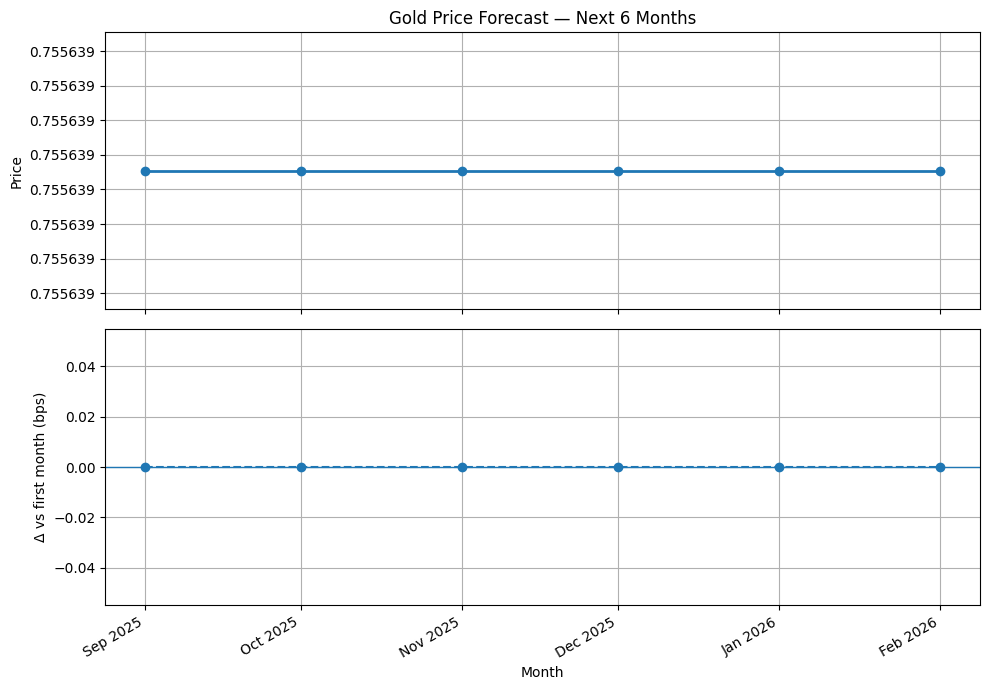

In [52]:

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from matplotlib.ticker import FormatStrFormatter

# --- Pick your forecast DF and standardize column names ---
if 'six_month_fcst' in globals():
    fc = _fc.rename(columns={'yhat': 'Predicted Price'}).copy()
elif 'fcst' in globals():
    fc = _fc.rename(columns={'yhat': 'Predicted Price'}).copy()
else:
    raise NameError("No forecast found. Define `six_month_fcst` (TFT) or `fcst` (Prophet) first.")

fc['ds'] = pd.to_datetime(fc['ds'])
fc['Month'] = fc['ds'].dt.strftime('%b %Y')

# --- Table with more precision + deltas ---
base = float(fc['Predicted Price'].iloc[0])
fc['Δ abs'] = fc['Predicted Price'] - base
fc['Δ %']   = (fc['Predicted Price'] / base - 1.0) * 100.0
fc['Δ bps'] = fc['Δ %'] * 100.0  # basis points

display(fc[['Month', 'Predicted Price', 'Δ abs', 'Δ %', 'Δ bps']].round({'Predicted Price': 6, 'Δ abs': 6, 'Δ %': 4, 'Δ bps': 2}))

# --- Figure: (1) absolute values with tight y-limits, (2) delta in bps ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), sharex=True)

# 1) Absolute prices with tight y-limits and more decimals
ax1.plot(fc['ds'], fc['Predicted Price'], marker='o', linewidth=2)
ymin, ymax = fc['Predicted Price'].min(), fc['Predicted Price'].max()
pad = max((ymax - ymin) * 0.25, 1e-8)  # ensure small pad even if nearly flat
ax1.set_ylim(ymin - pad, ymax + pad)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.6f'))
ax1.set_title('Gold Price Forecast — Next 6 Months')
ax1.set_ylabel('Price')
ax1.grid(True)

# 2) Change vs first month in basis points (tiny moves become visible)
ax2.plot(fc['ds'], fc['Δ bps'], marker='o', linestyle='--')
ax2.axhline(0, linewidth=1)
ax2.set_ylabel('Δ vs first month (bps)')
ax2.set_xlabel('Month')
ax2.grid(True)

# Nice month ticks
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
fig.autofmt_xdate()

plt.tight_layout()
plt.show()

# Now we predict the future